In [166]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from chesswinnerprediction import plot_pie, plot_draw_percentage_by_base_time
from config import PROCESSED_FOLDER_PATH

In [206]:
data_path = os.path.join(PROCESSED_FOLDER_PATH, "lichess_db_standard_rated_2017-10.csv")
df = pd.read_csv(data_path)

In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005186 entries, 0 to 1005185
Data columns (total 17 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Event              1005186 non-null  object 
 1   WhiteElo           1005186 non-null  int64  
 2   BlackElo           1005186 non-null  int64  
 3   TimeControl        1005186 non-null  object 
 4   Result             1005186 non-null  object 
 5   MeanElo            1005186 non-null  float64
 6   EloDiff            1005186 non-null  int64  
 7   BaseTime           1005186 non-null  int64  
 8   IncrementTime      1005186 non-null  int64  
 9   ZeroIncrementTime  1005186 non-null  int64  
 10  ResultEncoded      1005186 non-null  int64  
 11  WhiteWin           1005186 non-null  int64  
 12  BlackWin           1005186 non-null  int64  
 13  Draw               1005186 non-null  int64  
 14  DrawEventProb      1005186 non-null  float64
 15  WhiteWinEventProb  1005186 non-n

In [208]:
df.head()

,Event,WhiteElo,BlackElo,TimeControl,Result,MeanElo,EloDiff,BaseTime,IncrementTime,ZeroIncrementTime,ResultEncoded,WhiteWin,BlackWin,Draw,DrawEventProb,WhiteWinEventProb,BlackWinEventProb
0,Rated Classical game,1624,1721,600+3,1-0,1672.5,-97,600,3,0,0,1,0,0,0.033082,0.491932,0.474985
1,Rated Blitz tournament,1582,1472,180+2,0-1,1527.0,110,180,2,0,1,0,1,0,0.044876,0.492335,0.462789
2,Rated Classical game,2252,1938,900+14,1/2-1/2,2095.0,314,900,14,0,2,0,0,1,0.033082,0.491932,0.474985
3,Rated Classical game,1880,1634,600+0,0-1,1757.0,246,600,0,1,1,0,1,0,0.033082,0.491932,0.474985
4,Rated Classical game,1983,1912,600+0,1-0,1947.5,71,600,0,1,0,1,0,0,0.033082,0.491932,0.474985


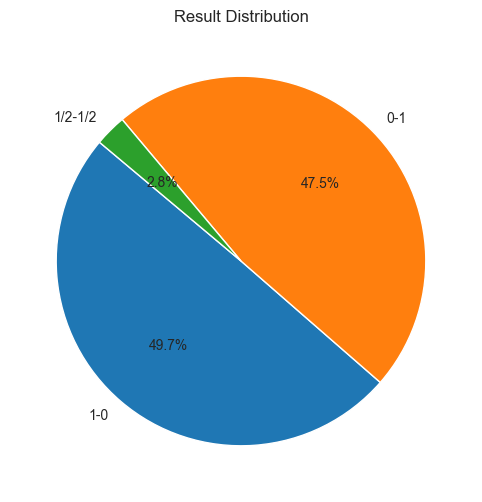

In [209]:
_, axs = plt.subplots(figsize=(12, 6))
plot_pie(axs, df, "Result", "Result Distribution", threshold=0)
plt.show()

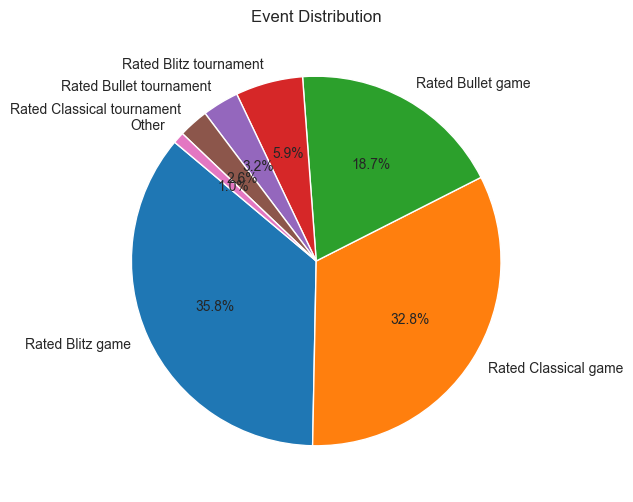

In [210]:
_, axs = plt.subplots(figsize=(12, 6))
plot_pie(axs, df, "Event", "Event Distribution", threshold=0.025)
plt.show()

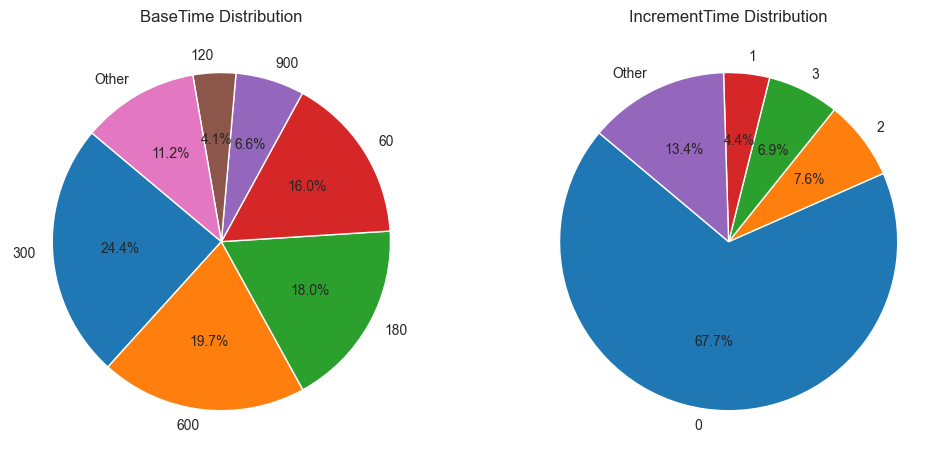

In [211]:
_, axs = plt.subplots(1, 2, figsize=(12, 6))
plot_pie(axs[0], df, "BaseTime", "BaseTime Distribution", threshold=0.03)
plot_pie(axs[1], df, "IncrementTime", "IncrementTime Distribution", threshold=0.04)
plt.show()

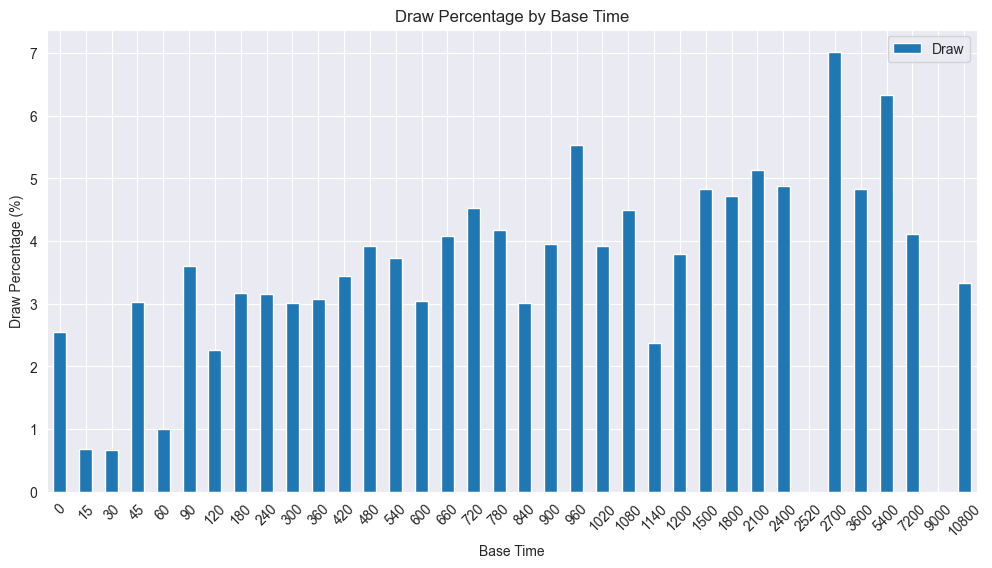

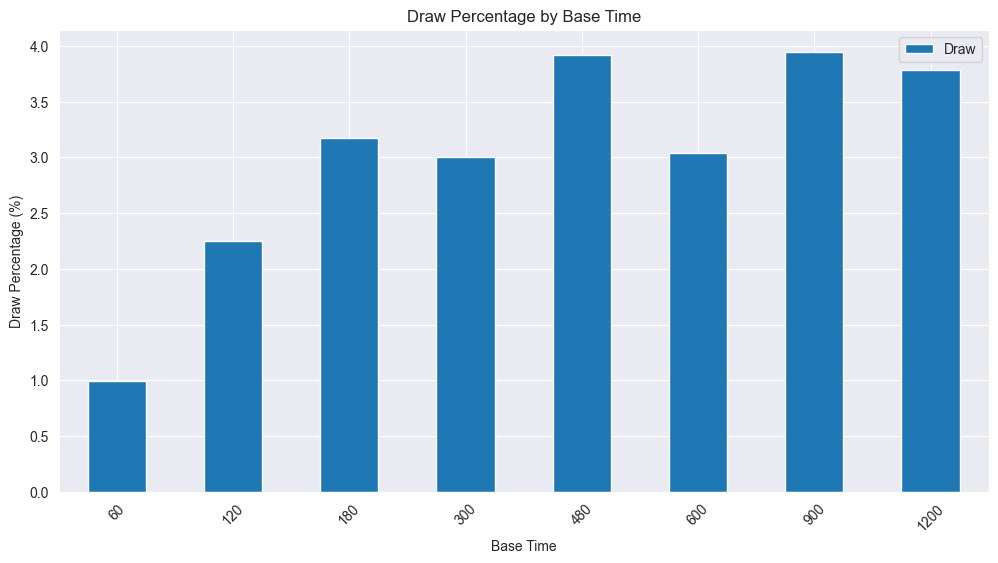

In [212]:
plot_draw_percentage_by_base_time(df)
plot_draw_percentage_by_base_time(df, base_times=8)

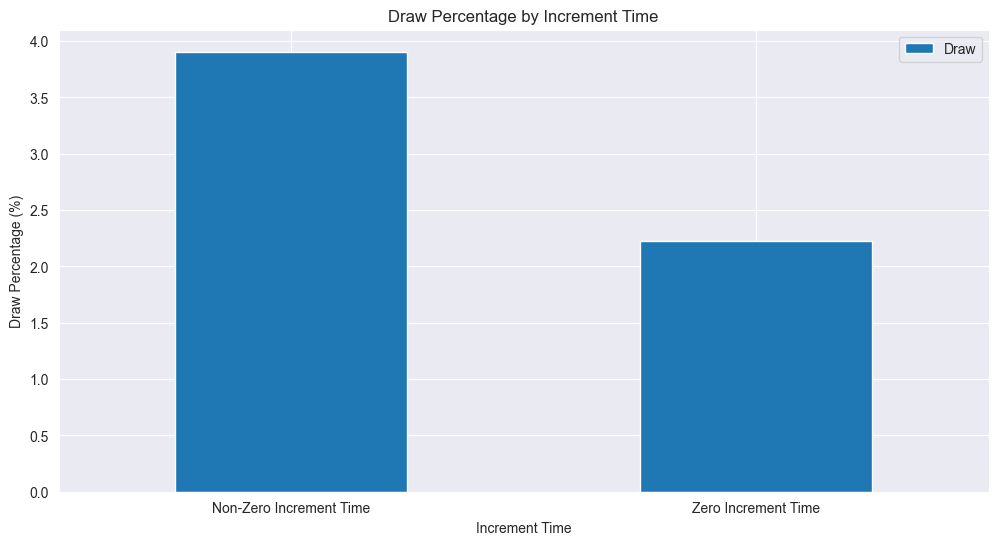

In [213]:
increment_time_df = df[["ZeroIncrementTime", "Draw"]].copy()
increment_time_df["ZeroIncrementTime"] = increment_time_df["ZeroIncrementTime"].map(
    {0: "Non-Zero Increment Time", 1: "Zero Increment Time"}
)
pct_draw_values = increment_time_df.groupby("ZeroIncrementTime").mean() * 100

ax = pct_draw_values.plot(kind="bar", figsize=(12, 6))
ax.set_title("Draw Percentage by Increment Time")
ax.set_ylabel("Draw Percentage (%)")
ax.set_xlabel("Increment Time")
plt.xticks(rotation=0)
plt.show()

In [214]:
def estimate_prediction_by_elo(data_df: pd.DataFrame, count_draws=True):
    white_elo_more_than_black = data_df["WhiteElo"] > data_df["BlackElo"]
    
    white_win_condition = white_elo_more_than_black & (data_df["WhiteWin"] == 1)
    black_win_condition = ~white_elo_more_than_black & (data_df["BlackWin"] == 1)
    
    right_predictions = len(data_df[white_win_condition]) + len(data_df[black_win_condition])
    
    if count_draws:
        return right_predictions / len(data_df)
    return right_predictions / len(data_df[data_df["Draw"] != 1])

In [215]:
estimate_prediction_by_elo(df, count_draws=False)

0.5903913644037448

In [216]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler


In [217]:
df = pd.get_dummies(df, columns=["Event"], dtype=np.int8, prefix="", prefix_sep="")

In [218]:
df.drop(columns=["TimeControl", "Result"], inplace=True)

In [219]:
df.head()

,WhiteElo,BlackElo,MeanElo,EloDiff,BaseTime,IncrementTime,ZeroIncrementTime,ResultEncoded,WhiteWin,BlackWin,...,WhiteWinEventProb,BlackWinEventProb,Rated Blitz game,Rated Blitz tournament,Rated Bullet game,Rated Bullet tournament,Rated Classical game,Rated Classical tournament,Rated UltraBullet game,Rated UltraBullet tournament
0,1624,1721,1672.5,-97,600,3,0,0,1,0,...,0.491932,0.474985,0,0,0,0,1,0,0,0
1,1582,1472,1527.0,110,180,2,0,1,0,1,...,0.492335,0.462789,0,1,0,0,0,0,0,0
2,2252,1938,2095.0,314,900,14,0,2,0,0,...,0.491932,0.474985,0,0,0,0,1,0,0,0
3,1880,1634,1757.0,246,600,0,1,1,0,1,...,0.491932,0.474985,0,0,0,0,1,0,0,0
4,1983,1912,1947.5,71,600,0,1,0,1,0,...,0.491932,0.474985,0,0,0,0,1,0,0,0


In [220]:
data_without_draws = df[df["Draw"] != 1]

In [239]:
X = df.drop(columns=["ResultEncoded", "WhiteWin", "BlackWin", "Draw"])
y = df["ResultEncoded"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [240]:
class_weights = compute_class_weight("balanced", classes=np.unique(y), y=y)
class_weights = dict(zip(np.unique(y), class_weights))
class_weights

{np.int64(0): np.float64(0.6706927474498374),
 np.int64(1): np.float64(0.7012981032873283),
 np.int64(2): np.float64(12.037002442879723)}

In [241]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

In [242]:
clf = LogisticRegression(class_weight=class_weights, random_state=42, max_iter=100, solver="liblinear", penalty="l1")

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Classification report
report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Visualize the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Get feature importance (coefficients)
importance = np.abs(clf.coef_[0])

# Create a DataFrame for feature importance
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()